In [1]:
import sys
import torch
import os
from torch.nn import functional as F
sys.path.insert(0, '../src')
from clean_text import text_preprocessing_pipeline
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
model_name = 'roberta-base'
MAX_LEN = 200

# PCA on a summary vector from roberta

In [36]:
df = pd.read_csv(os.getcwd() + '/../data/perfect_dataset.csv')
df = df.sample(frac=0.1).reset_index(drop=True)
# clean the text
df['text'] = df['text'].apply(text_preprocessing_pipeline)
# get distinct tags
target_cols = df['tag'].unique()
# one hot encode the tags
encoder = OneHotEncoder()
label = encoder.fit_transform(df[['tag']]).toarray()
# append one hot encoded label to the dataframe with distinct tags as columns
df = pd.concat([df, pd.DataFrame(label, columns=target_cols)], axis=1)
# reset the index
df.reset_index(drop=True, inplace=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l1 = torch.nn.Linear(768, 256)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        #features = F.relu(self.l1(features))
        # output_2 = self.l2(output_1)
        output = F.softmax(self.fc(features), dim=1)
        return output

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = BERTClass()
model.load_state_dict(torch.load(os.getcwd() + '/../model/model4.bin'))
model.to(device)

# from the model get only the features from the forward pass
def get_features(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)
    _, features = model.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
    return features.cpu().detach().numpy()

In [ ]:
df['features'] = df['text'].apply(get_features)
df.features = df.features.apply(lambda x: x.reshape(-1))
pca = PCA(n_components=2)
pca = pca.fit(df['features'].to_list())
df['pca'] = df['features'].apply(lambda x: pca.transform([x])[0])
df['pca_x'] = df['pca'].apply(lambda x: x[0])
df['pca_y'] = df['pca'].apply(lambda x: x[1])

In [ ]:
# Plot the data
plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', hue='tag', data=df)
plt.savefig('pca.png')

# Accuracy | Final dataset | Classical ML + roberta

roberta random sample test 7000 accuracy 0.7477142857142857

tf-idf sgd 0.6252857142857143 

tf-idf logreg 0.6317142857142857 

tf-idf knn 0.2927142857142857

tf-df random forest 0.614

tf-idf grad boost 0.61

In [14]:
metrics = pd.DataFrame(columns=['model', 'vectorization', 'accuracy'])

metrics = pd.concat([metrics, pd.DataFrame({'model': 'SGD', 'vectorization': 'tf-idf', 'accuracy': 0.6252857142857143}, index=[0])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'LogReg', 'vectorization': 'tf-idf', 'accuracy': 0.6317142857142857}, index=[1])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'KNN', 'vectorization': 'tf-idf', 'accuracy': 0.2927142857142857}, index=[2])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'RandFor', 'vectorization': 'tf-idf', 'accuracy': 0.614}, index=[3])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'GradBoost', 'vectorization': 'tf-idf', 'accuracy': 0.61}, index=[4])])

metrics = pd.concat([metrics, pd.DataFrame({'model': 'SGD', 'vectorization': 'BoW', 'accuracy': 0.5752857142857143}, index=[5])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'LogReg', 'vectorization': 'BoW', 'accuracy': 0.5757142857142857}, index=[6])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'KNN', 'vectorization': 'BoW', 'accuracy': 0.4184285714285714}, index=[7])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'RandFor', 'vectorization': 'BoW', 'accuracy': 0.6215714285714286}, index=[8])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'GradBoost', 'vectorization': 'BoW', 'accuracy': 0.6125714285714285}, index=[9])])

metrics = pd.concat([metrics, pd.DataFrame({'model': 'SGD', 'vectorization': 'N-grams BoW', 'accuracy': 0.5964285714285714}, index=[10])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'LogReg', 'vectorization': 'N-grams BoW', 'accuracy': 0.6207142857142857}, index=[11])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'KNN', 'vectorization': 'N-grams BoW', 'accuracy': 0.398}, index=[12])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'RandFor', 'vectorization': 'N-grams BoW', 'accuracy': 0.6128571428571429}, index=[13])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'GradBoost', 'vectorization': 'N-grams BoW', 'accuracy': 0.6147142857142858}, index=[14])])

metrics = pd.concat([metrics, pd.DataFrame({'model': 'NN', 'vectorization': 'tf-idf', 'accuracy': 0.6}, index=[15])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'NN', 'vectorization': 'BoW', 'accuracy': 0.603}, index=[16])])
metrics = pd.concat([metrics, pd.DataFrame({'model': 'NN', 'vectorization': 'N-grams BoW', 'accuracy': 0.594}, index=[17])])

metrics = pd.concat([metrics, pd.DataFrame({'model': 'Transfer learning NN', 'vectorization': 'Roberta', 'accuracy': 0.7477142857142857}, index=[18])])
metrics

/tmp/ipykernel_14233/3884787988.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame({'model': 'SGD', 'vectorization': 'tf-idf', 'accuracy': 0.6252857142857143}, index=[0])])


,model,vectorization,accuracy
0,SGD,tf-idf,0.625286
1,LogReg,tf-idf,0.631714
2,KNN,tf-idf,0.292714
3,RandFor,tf-idf,0.614000
4,GradBoost,tf-idf,0.610000
5,SGD,BoW,0.575286
6,LogReg,BoW,0.575714
7,KNN,BoW,0.418429
8,RandFor,BoW,0.621571
9,GradBoost,BoW,0.612571


In [15]:
metrics.to_csv('metrics.csv')

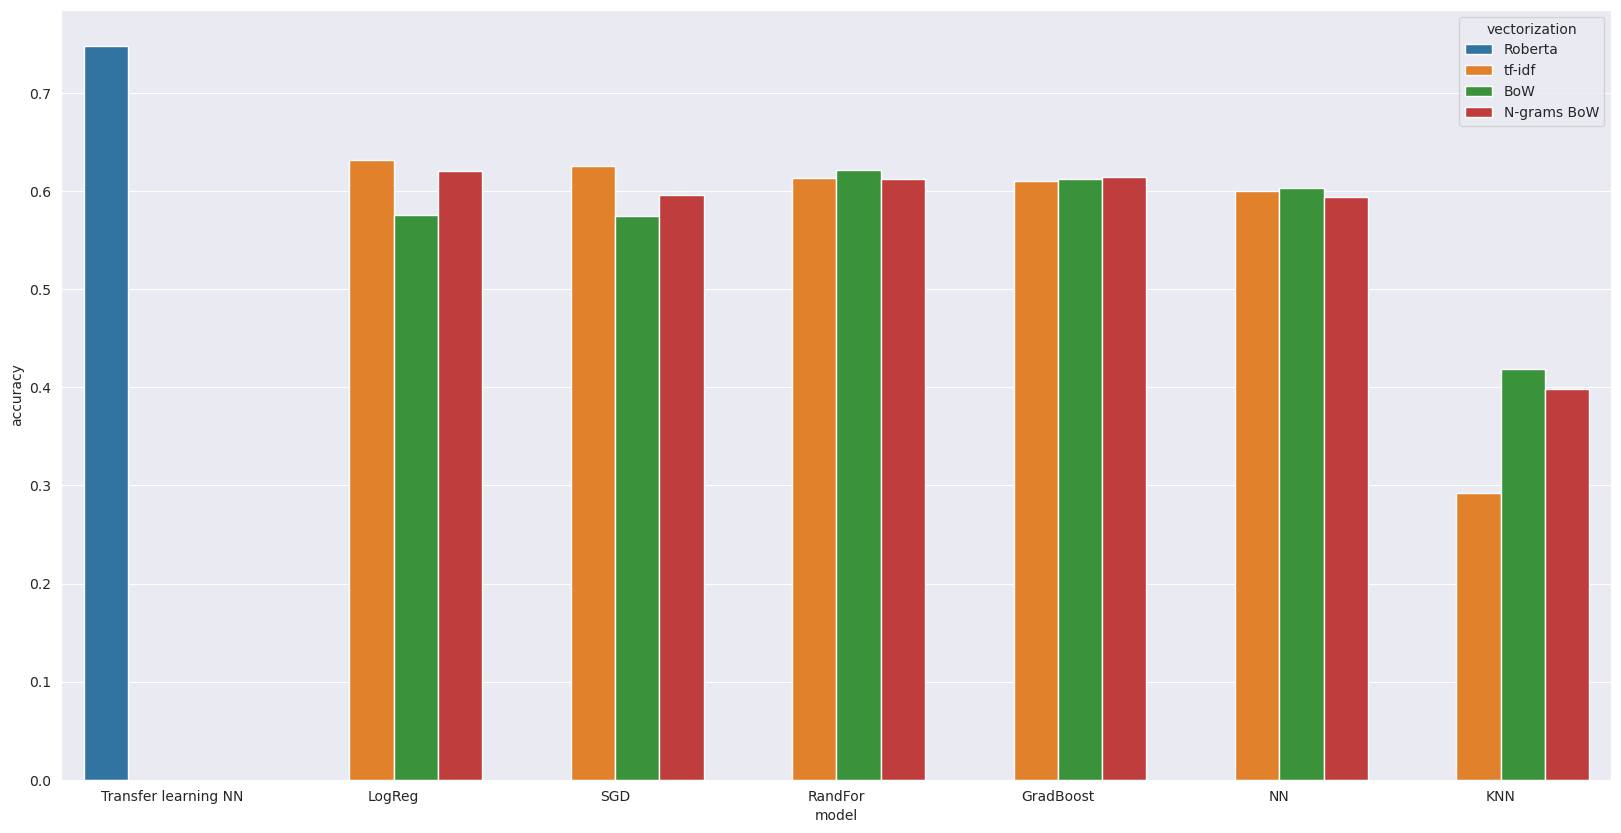

In [16]:
metrics_melted = metrics.sort_values(by='accuracy', ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x='model', y='accuracy', hue='vectorization', data=metrics_melted)

plt.savefig('metrics.png')
plt.show()